# CNN for urbansound8k

In [38]:
%matplotlib notebook
import matplotlib.pyplot as plt
from __future__ import print_function
import sys
import os
import h5py
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
np.random.seed(1337)  # for reproducibility

import keras
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K
from keras.models import Sequential
from keras.layers.advanced_activations import ELU
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers import AveragePooling2D
from keras.layers.normalization import BatchNormalization

In [8]:
PATH_HDF = '/misc/kcgscratch1/ChoGroup/keunwoo/urbansound8k_hdf/'
train_ = h5py.File(PATH_HDF + 'train.h5', 'r')
train_x, train_y = train_['melgram'], train_['y']

valid_ = h5py.File(PATH_HDF + 'valid.h5', 'r')
valid_x, valid_y = valid_['melgram'], valid_['y']

test_ = h5py.File(PATH_HDF + 'test.h5', 'r')
test_x, test_y = test_['melgram'], test_['y']

In [33]:
def urban_convnet(input_shape=(96, 188)):
    # number of convolutional filters to use
    nb_filters = 32
    # size of pooling area for max pooling
    # convolution kernel size
    kernel_size = (3, 3)
    nb_classes = 10 # phonemes

    model = Sequential()
    model.add(Reshape((1,) + input_shape, input_shape=input_shape))
    model.add(Convolution2D(nb_filters, 3, 3,
                            border_mode='same',
                            name='conv1',
                            init='he_normal'))
    model.add(Convolution2D(nb_filters, 3, 3,
                            border_mode='same',
                            name='conv1_2',
                            init='he_normal'))
    model.add(ELU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 4))) # (48, 47)
    model.add(Dropout(0.2))
    model.add(ZeroPadding2D(padding=(0, 1))) # (48, 49)    

    model.add(Convolution2D(nb_filters, 3, 3, border_mode='same', name='conv2', init='he_normal'))
    model.add(Convolution2D(nb_filters, 3, 3, border_mode='same', name='conv2_2', init='he_normal'))
    model.add(ELU())
    model.add(BatchNormalization())    
    model.add(MaxPooling2D((3, 3))) # (16, 16)
    model.add(Dropout(0.2))
    
    model.add(Convolution2D(nb_filters, 3, 3, border_mode='same', name='conv3', init='he_normal'))
    model.add(ELU())
    model.add(BatchNormalization())    
    model.add(MaxPooling2D((2, 2))) # (8, 8)
    model.add(Dropout(0.2))

    model.add(Convolution2D(nb_filters, 3, 3, border_mode='same', name='conv4', init='he_normal'))
    model.add(ELU())
    model.add(BatchNormalization())    
    model.add(MaxPooling2D((2, 2))) # (4, 4)
    model.add(Dropout(0.2))

    model.add(Convolution2D(nb_filters, 3, 3, border_mode='valid', 
                            name='conv5', init='he_normal')) # (2, 2)
    model.add(AveragePooling2D((2, 2)))
                            
    model.add(Flatten())
    model.add(Dense(nb_filters))
    model.add(ELU())
    model.add(Dropout(0.2))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    adam = keras.optimizers.Adam(lr=0.005)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    return model



In [ ]:
model = urban_convnet()
model.summary(90)

__________________________________________________________________________________________
Layer (type)                 Output Shape        Param #    Connected to                  
reshape_8 (Reshape)          (None, 1, 96, 188)  0          reshape_input_8[0][0]         
__________________________________________________________________________________________
conv1 (Convolution2D)        (None, 32, 96, 188) 320        reshape_8[0][0]               
__________________________________________________________________________________________
conv1_2 (Convolution2D)      (None, 32, 96, 188) 9248       conv1[0][0]                   
__________________________________________________________________________________________
elu_54 (ELU)                 (None, 32, 96, 188) 0          conv1_2[0][0]                 
__________________________________________________________________________________________
batchnormalization_7 (BatchNo(None, 32, 96, 188) 376        elu_54[0][0]                  

In [ ]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', 
                    patience=5, verbose=0, mode='auto')

check_pointer = keras.callbacks.ModelCheckpoint('best_weights.h5', 
                    monitor='val_loss', verbose=0, save_best_only=True, 
                    save_weights_only=True, mode='auto')

model.fit(train_x, train_y, validation_data=(valid_x, valid_y), shuffle='batch', batch_size=32,
          nb_epoch=100, callbacks=[early_stopper, check_pointer])

In [37]:
model.load_weights('best_weights.h5')
y_pred = model.predict_classes(test_x)
y_pred = np.eye(10)[y_pred]
print('')
print(accuracy_score(test_y, y_pred))

832/837 [============================>.] - ETA: 0s
0.707287933094


<IPython.core.display.Javascript object>


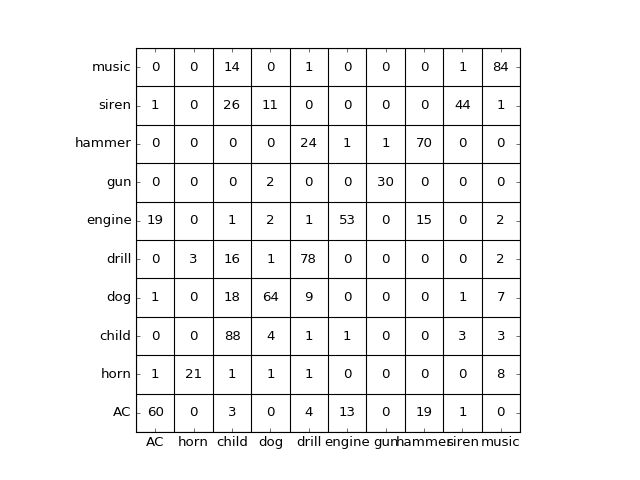

([<matplotlib.axis.YTick at 0x30ec6910>,
 <a list of 10 Text yticklabel objects>)

In [59]:
conf_arr = confusion_matrix(np.argmax(test_y[:], axis=1), 
                        np.argmax(y_pred, axis=1))
height, width = conf_arr.shape

fig = plt.figure('confusion matrix')
ax = fig.add_subplot(111, aspect='equal')
for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), ha='center', va='center')

offset = .5    
ax.set_xlim(-offset, width - offset)
ax.set_ylim(-offset, height - offset)

ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

labels = ['AC', 'horn', 'child', 'dog', 'drill', 'engine', 'gun', 'hammer', 'siren', 'music']
plt.xticks(range(width), labels)
plt.yticks(range(height), labels)
# plt.savefig('confusion_matrix.png', format='png')

## Close hdf files
yeah if you want..

In [60]:
train_.close()
valid_.close()
test_.close()